In [43]:
import torch
import pennylane as qml

import matplotlib.pyplot as plt
plt.style.use('./pptnqfe.mplstyle')

from qulearn.hat_basis import HatBasis
from qulearn.qlayer import HatBasisQFE, MeasurementLayer, MeasurementType

# Section 5.2

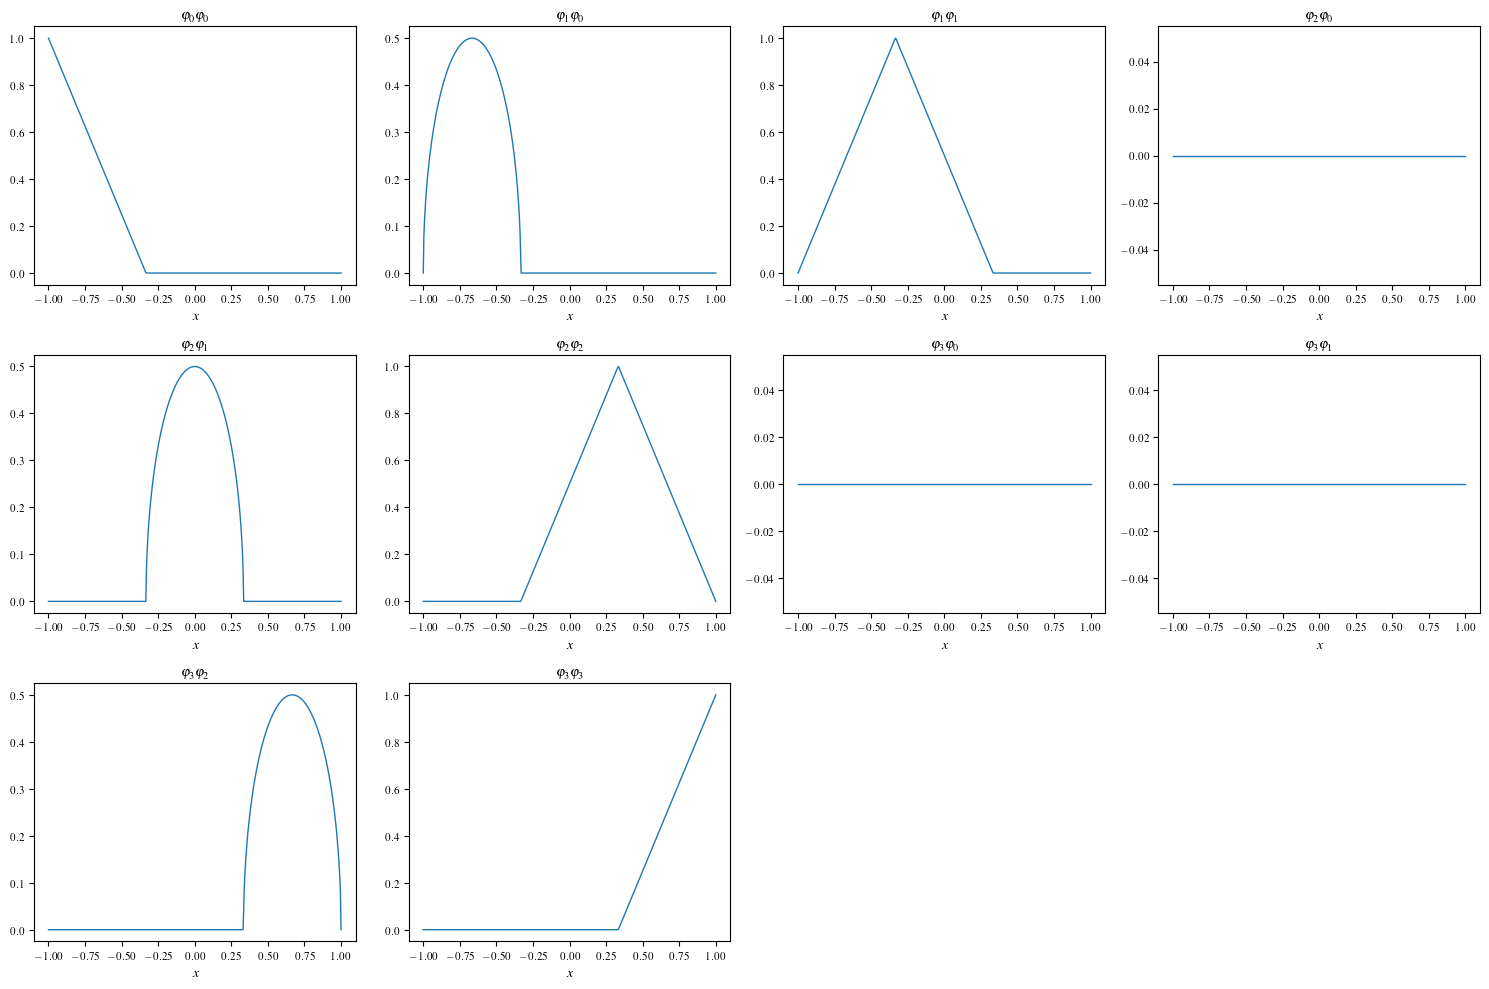

In [44]:
num_qubits = 2
num_nodes = 2**num_qubits
a = -1.0
b = 1.0
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)

num_pnts = 500
xvals = torch.linspace(-1.0, 1.0, num_pnts)
basis_vectors = hat_basis.eval_basis_vector(xvals)
basis_vectors = torch.sqrt(basis_vectors)

num_subplots = num_nodes * (num_nodes + 1) // 2
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
axs_flat = axs.flatten()

subplot_idx = 0
for i in range(num_nodes):
    for j in range(i + 1):
        axs_flat[subplot_idx].plot(xvals, basis_vectors[:, i] * basis_vectors[:, j])
        axs_flat[subplot_idx].set_title(f'$\\varphi_{i}\\varphi_{j}$')
        axs_flat[subplot_idx].set_xlabel('$x$')
        subplot_idx += 1

for idx in range(subplot_idx, len(axs_flat)):
    fig.delaxes(axs_flat[idx])

plt.tight_layout()
plt.savefig('./figures/basis_funcs.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [45]:
num_qubits = 5
num_nodes = 2**num_qubits
a = -1.0
b = 1.0
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)

embed = HatBasisQFE(wires=num_qubits, basis=hat_basis, sqrt=True, normalize=False)
obs = qml.PauliZ(0)
model = MeasurementLayer(embed, observables=obs, measurement_type=MeasurementType.Expectation)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0])
print(drawer(x))

0: ──────────────────────╭U(M2)─┤  <Z>
1: ───────────────╭U(M1)─╰U(M2)─┤     
2: ────────╭U(M1)─╰U(M1)────────┤     
3: ─╭U(M0)─╰U(M1)───────────────┤     
4: ─╰U(M0)──────────────────────┤     


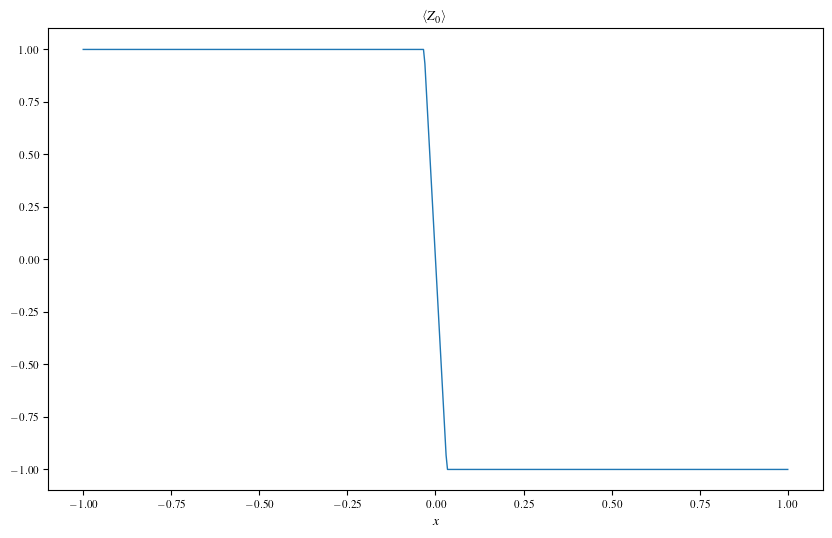

In [46]:
num_pnts = 500
xvals = torch.linspace(-1.0, 1.0, num_pnts).unsqueeze(-1)
yvals = model(xvals)

plt.figure(figsize=(10, 6))
plt.plot(xvals, yvals)
plt.xlabel('$x$')
plt.title("$\langle Z_0\\rangle$")
plt.savefig('./figures/z0.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [47]:
obs = qml.PauliZ(num_qubits-1)
model = MeasurementLayer(embed, observables=obs, measurement_type=MeasurementType.Expectation)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0])
print(drawer(x))

0: ──────────────────────╭U(M2)─┤     
1: ───────────────╭U(M1)─╰U(M2)─┤     
2: ────────╭U(M1)─╰U(M1)────────┤     
3: ─╭U(M0)─╰U(M1)───────────────┤     
4: ─╰U(M0)──────────────────────┤  <Z>


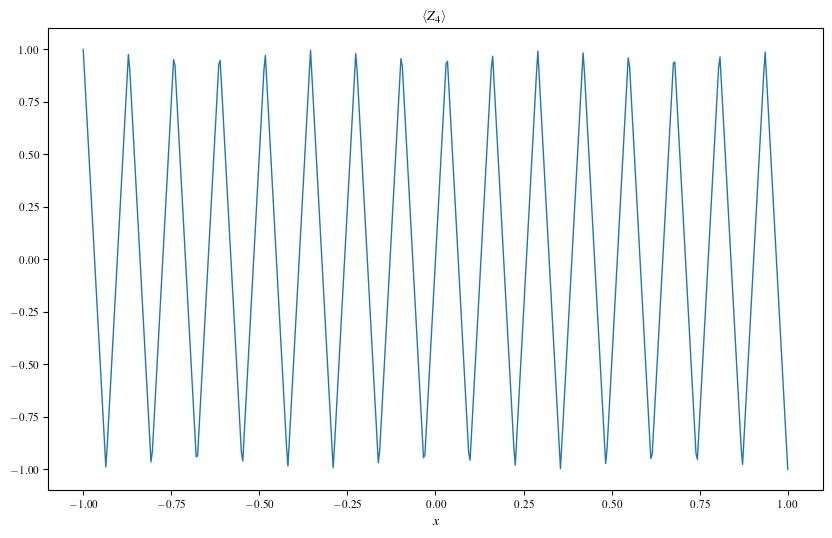

In [48]:
yvals = model(xvals)
plt.figure(figsize=(10, 6))
plt.plot(xvals, yvals)
plt.xlabel('$x$')
plt.title("$\langle Z_4\\rangle$")
plt.savefig('./figures/zn.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [49]:
obs = qml.PauliX(4)
model = MeasurementLayer(embed, observables=obs, measurement_type=MeasurementType.Expectation)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0])
print(drawer(x))

0: ──────────────────────╭U(M2)─┤     
1: ───────────────╭U(M1)─╰U(M2)─┤     
2: ────────╭U(M1)─╰U(M1)────────┤     
3: ─╭U(M0)─╰U(M1)───────────────┤     
4: ─╰U(M0)──────────────────────┤  <X>


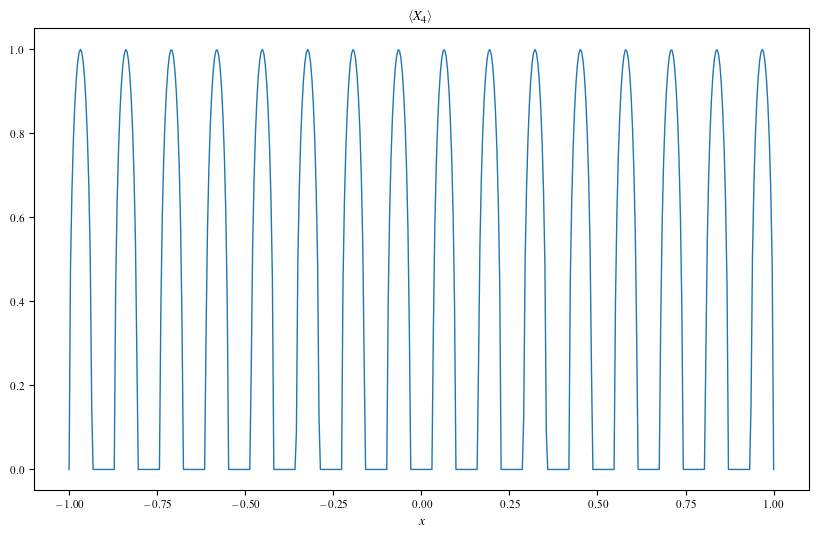

In [50]:
yvals = model(xvals)
plt.figure(figsize=(10, 6))
plt.plot(xvals, yvals)
plt.xlabel('$x$')
plt.title("$\langle X_4\\rangle$")
plt.savefig('./figures/xn.pdf', format='pdf', bbox_inches='tight')
plt.show()